In [1]:
import os
import time
import pickle
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import special, integrate, optimize, stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gaussian_preact as gpre
from gaussian_preact import find_density, find_activation, ParameterizedFunction, Integrand, \
    ActivationFunction, ActivationFunctionPos, ActivationFunctionPosTraining

torch.set_default_dtype(torch.float64)

plt.rcParams['text.usetex'] = 'True'
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern}'

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]
path_objects = './objects/'

#lst_theta = [2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]    # extensive
lst_theta = [2.05, 2.50, 3.00, 4.00, 5.00, 7.00, 10.00]    # as in the paper
#lst_theta = [2.11]    # for testing

cmap = plt.get_cmap('hot')
col = lambda theta: cmap(.5 * lst_theta.index(theta)/(max(len(lst_theta) - 1, 1)))

# Compute a *positive* interpolation of the activation function $\phi_{\theta}$

The densities should have been first computed.

In [3]:
# Load the densities
dct_densities = {}
for theta in lst_theta:
    dct_load = pickle.load(open('./objects/' + 'DensityFunc_theta-{:.2f}.pkl'.format(theta), 'rb'))
    dct_densities[theta] = dct_load['density']

In [4]:
def build_density_no_torch(density):
    def density_no_torch(x):
        with torch.no_grad():
            return density(x)
        
    return density_no_torch

In [5]:
# Interpolation parameters
xmin = -10
xmax = 10
xnum = 800
inputs = torch.linspace(xmin, xmax, xnum)

In [6]:
# Initialize storage dicts
dct_act_interpolation_x = {}
dct_act_interpolation_y = {}

In [7]:
for theta in lst_theta:
    # Build the density function without autograd (improves the computation speed)
    density = build_density_no_torch(dct_densities[theta])
    
    # Compute an interpolation of the related activation function
    act_interpolation = torch.empty_like(inputs)
    for i, x in enumerate(inputs):
        y = stats.norm.sf(x)
        act_interpolation[i] = optimize.brentq(lambda t: integrate.quad(density, t, np.inf)[0] - y, 0, 100)
    
    act_interpolation[0] = 0
    
    # Store the result
    dct_act_interpolation_x[theta] = inputs
    dct_act_interpolation_y[theta] = act_interpolation

In [8]:
# Store the interpolations
for theta in lst_theta:
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    pickle.dump({'act_interpolation_x': act_inter_x, 'act_interpolation_y': act_inter_y}, \
        file = open('./objects/' + 'ActInterpolation_theta-{:.2f}_pos.pkl'.format(theta), 'wb'))

(-10.0, 10.0)

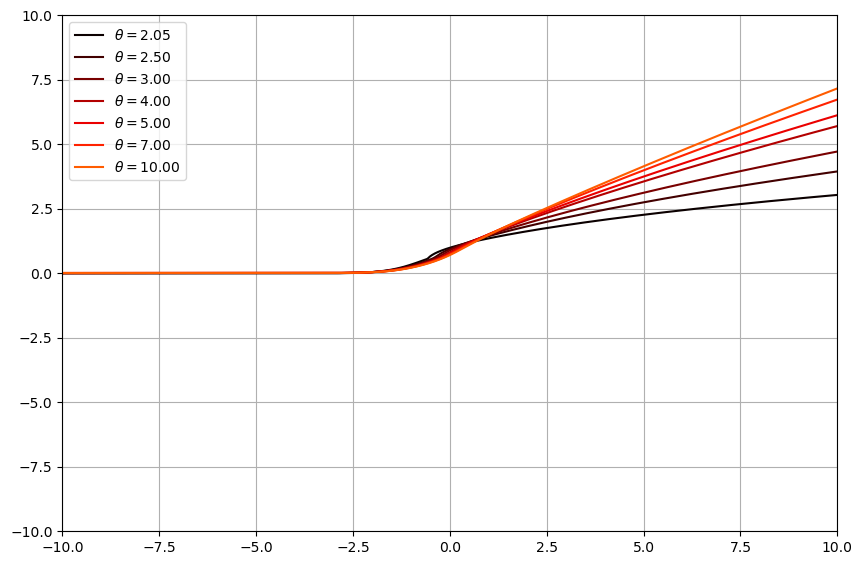

In [9]:
# Plot the interpolations
for theta in lst_theta:
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    plt.plot(act_inter_x, act_inter_y, label = r'$\theta = {:.2f}$'.format(theta), c = col(theta))
    
plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)

(-2.5, 2.5)

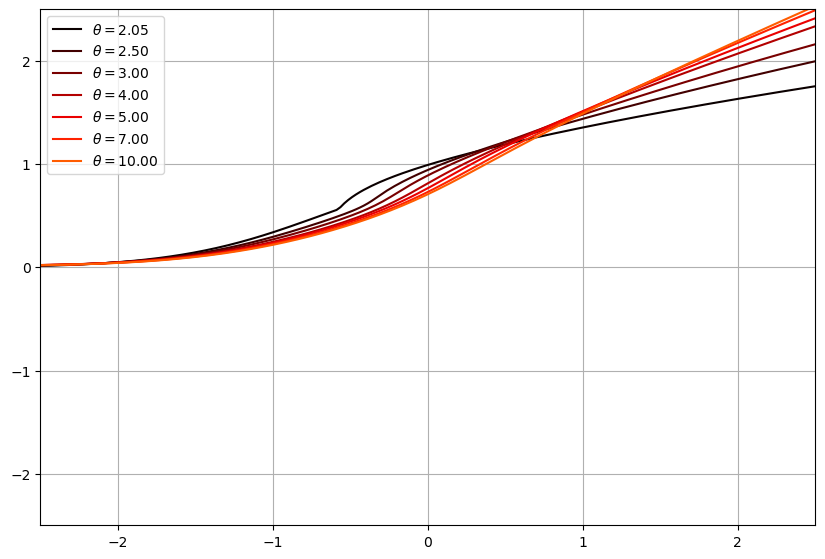

In [10]:
# Plot the interpolations
for theta in lst_theta:
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    plt.plot(act_inter_x, act_inter_y, label = r'$\theta = {:.2f}$'.format(theta), c = col(theta))
    
plt.legend()
plt.grid()
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

# Find an approximation of $\phi_{\theta}$ that is computationally efficient

In [172]:
# Load the interpolations
dct_act_interpolation_x = {}
dct_act_interpolation_y = {}
for theta in lst_theta:
    dct_load = pickle.load(open('./objects/' + 'ActInterpolation_theta-{:.2f}_pos.pkl'.format(theta), 'rb'))
    dct_act_interpolation_x[theta] = dct_load['act_interpolation_x']
    dct_act_interpolation_y[theta] = dct_load['act_interpolation_y']

In [173]:
# Set the initial parameters of the activation function
a = 1
b = 1
c = 1
d = .01

f = 1
g = .01
h = 0

# Build the inputs
"""
In the context of Gaussian pre-activations, we must ensure that our proposition of activation function
fits well the interpolation where the Normal(0, 1) is concentrated. This is why we build 'inputs_gauss'.

However, the set 'inputs_gauss' is highly concentrated around 0, and it would not impose any constraint,
for instance, on the interval [4, 10]. So, we artificially add some points to 'inputs_gauss' to build
the new set 'inputs', which covers the interval [-xmax, xmax] (where xmax can be set to 10).
"""
xnum_gauss = 1000
inputs_gauss = torch.tensor(np.sqrt(2) * special.erfinv(np.linspace(-1 + 1/xnum_gauss, 1 - 1/xnum_gauss, 
                                                                    2*xnum_gauss - 1)))
xmax = 10
xnum_compl = 50
inputs = torch.concat((torch.linspace(-xmax, inputs_gauss[0], xnum_compl),
                       inputs_gauss,
                       torch.linspace(inputs_gauss[-1], xmax, xnum_compl)))

In [174]:
# Optimization parameters
lr = .01
epochs = 10000

In [175]:
# Initialize storage dicts
dct_activations = {}
dct_errors = {}

In [186]:
# Compute the activation function for each theta
for theta in lst_theta:
    # Get the interpolation
    act_inter_x = dct_act_interpolation_x[theta]
    act_inter_y = dct_act_interpolation_y[theta]
    
    # Initialize the activation function to train
    activation = ActivationFunctionPosTraining(theta, a, b, c, d, f, g, h)
    
    # Perform the training
    activation, error = find_activation(theta, activation, act_inter_x, act_inter_y, inputs,
            lr = lr, epochs = epochs)
    
    dct_activations[theta] = activation
    dct_errors[theta] = error

In [173]:
# Store the activation functions
for theta in lst_theta:
    activation = dct_activations[theta]
    error = dct_errors[theta]
    torch.save({'activation': ActivationFunctionPos(activation), 'error': error}, \
               './objects/' + 'ActFunctionPos_theta-{:.2f}.pkl'.format(theta))

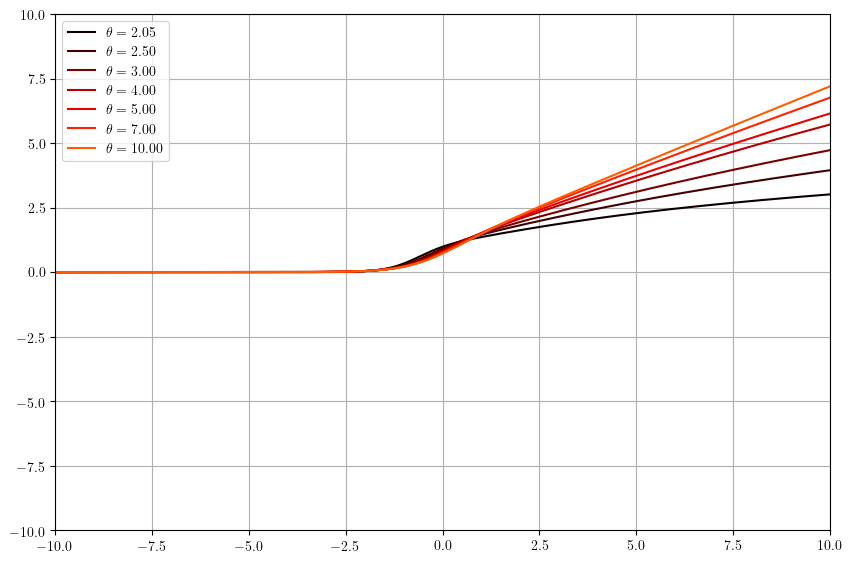

In [5]:
matplotlib.rcParams['figure.figsize'] = [10, 6.7]

tens_x = torch.linspace(-10, 10, 400)

# Plot the activation functions
for theta in lst_theta:
    activation = dct_activations[theta]
    plt.plot(tens_x, activation.forward_ng(tens_x), label = r'$\theta = {:.2f}$'.format(theta),
            c = col(theta))

plt.legend()
plt.grid()
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.savefig('ActivationPositive.pdf')